In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import bigquery
!pip install db-dtypes
!pip install google-cloud-bigquery
!pip install google-cloud-bigquery-storage
from tensorflow.keras.utils import to_categorical

2025-06-03 15:59:44.256988: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-03 15:59:44.258604: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 15:59:44.267701: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 15:59:44.278935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748962784.291925   49263 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748962784.29

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
def get_data_from_bq(
        gcp_project:str,
        query:str,
        data_has_header=True
    ) -> pd.DataFrame:
    """
    Retrieve `query` data from BigQuery
    """
    client = bigquery.Client(project=gcp_project)
    query_job = client.query(query)
    result = query_job.result()
    df = result.to_dataframe()
    df = df.astype("float64")
    return df

GCP_PROJECT = "skin-scan-461716"
BQ_DATASET = "skin_scan"

query = f"""
        SELECT *
        FROM `{GCP_PROJECT}`.{BQ_DATASET}.train_28x28
    """

data = get_data_from_bq(f"{GCP_PROJECT}", query)

In [3]:
data

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,179.0,138.0,169.0,180.0,137.0,169.0,182.0,139.0,169.0,186.0,...,189.0,161.0,192.0,189.0,161.0,189.0,187.0,157.0,183.0,4.0
1,139.0,74.0,78.0,148.0,80.0,85.0,160.0,91.0,99.0,170.0,...,9.0,8.0,8.0,15.0,14.0,16.0,21.0,18.0,22.0,4.0
2,65.0,41.0,57.0,130.0,95.0,115.0,173.0,136.0,161.0,187.0,...,20.0,9.0,18.0,19.0,10.0,19.0,17.0,10.0,17.0,4.0
3,201.0,159.0,176.0,207.0,155.0,174.0,207.0,150.0,163.0,207.0,...,83.0,86.0,138.0,104.0,101.0,161.0,117.0,102.0,156.0,6.0
4,229.0,188.0,208.0,237.0,191.0,216.0,235.0,179.0,195.0,233.0,...,106.0,105.0,168.0,131.0,122.0,193.0,142.0,121.0,184.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,26.0,17.0,27.0,52.0,38.0,51.0,47.0,32.0,45.0,38.0,...,37.0,24.0,36.0,54.0,37.0,51.0,41.0,28.0,41.0,2.0
10011,183.0,119.0,145.0,213.0,146.0,177.0,222.0,146.0,181.0,224.0,...,227.0,126.0,173.0,228.0,122.0,160.0,224.0,96.0,118.0,1.0
10012,245.0,129.0,140.0,247.0,129.0,142.0,248.0,132.0,139.0,248.0,...,234.0,129.0,131.0,230.0,122.0,127.0,226.0,120.0,122.0,4.0
10013,253.0,168.0,182.0,254.0,171.0,185.0,254.0,164.0,180.0,254.0,...,247.0,175.0,167.0,244.0,171.0,163.0,243.0,172.0,163.0,4.0


In [4]:
X = data.drop('label', axis=1)

In [5]:
y = data['label']

In [6]:
y = np.array(y).astype(int).reshape(-1)

In [7]:
X = X.values / 255.0 
X = X.reshape(-1, 28, 28, 3)  


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)





In [9]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [18]:
print(y_train.shape)  # Should be (num_samples, 7)
print(y_test.shape)

(7010, 7)
(3005, 7)


In [19]:
#model = Sequential([
  #  Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
  #  MaxPooling2D(pool_size=(2, 2)),
  #  Conv2D(64, (3, 3), activation='relu'),
  #  MaxPooling2D(pool_size=(2, 2)),
  #  Flatten(),
  #  Dense(128, activation='relu'),
  #  Dropout(0.5),
  #  Dense(7, activation='softmax') ])

#model.compile(optimizer='adam',
              #loss='categorical_crossentropy',
             # metrics=['accuracy'])


#model.summary()



In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','recall'])


model.summary()


/home/vedutla/.pyenv/versions/3.12.9/envs/skin_scan_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,111 (1.49 MB)

 Trainable params: 390,663 (1.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=32)


Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6296 - loss: 1.2094 - recall: 0.5651 - val_accuracy: 0.0762 - val_loss: 1.9293 - val_recall: 0.0200
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7073 - loss: 0.8038 - recall: 0.6164 - val_accuracy: 0.3867 - val_loss: 1.4822 - val_recall: 0.1331
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7304 - loss: 0.7631 - recall: 0.6330 - val_accuracy: 0.6709 - val_loss: 1.4608 - val_recall: 0.6629
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7567 - loss: 0.6861 - recall: 0.6671 - val_accuracy: 0.6849 - val_loss: 1.0155 - val_recall: 0.6709
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7479 - loss: 0.7107 - recall: 0.6583 - val_accuracy: 0.7145 - val_loss: 0.9433 - val_recall: 0.6493
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7411 - loss: 0.7113 - recall: 0.6621 - val_accuracy: 0.6672 - val_loss: 0.9148 - val_recall: 0.60

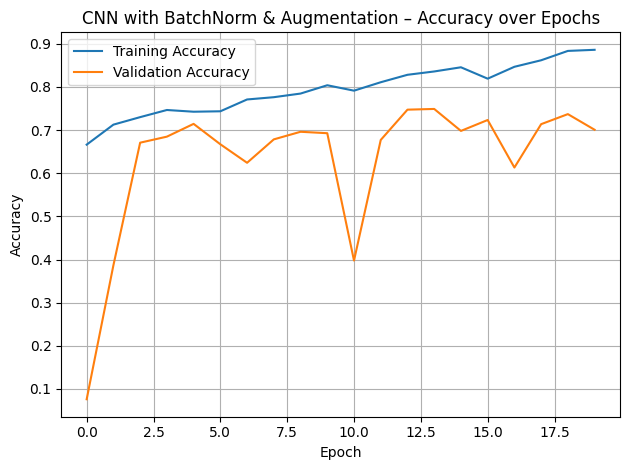

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('CNN with BatchNorm & Augmentation – Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
model.evaluate(X_test,y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6975 - loss: 1.1047 - recall: 0.6753


[1.1047204732894897, 0.700831949710846, 0.6768718957901001]

In [26]:
model.metrics_names

['loss', 'compile_metrics']